##FACE RECOGNITION


*Francesco Esposito*  5108223

*Alessandro Esposito*  5112139

**Face Recognition**

The project aims at the recognition of images through the use of new CNN architectures. In order to implement our model we choosed a dataset that distinguishes images representing photographs of real people ('Celebrities'), from drawn faces, sketches, animals, anime and objects.

The dataset can be found at this link: https://www.kaggle.com/datasets/pawankumarsahu/multidomain-human-face-classification-dataset?resource=download  

In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0
!pip install split-folders
import glob
from torch.utils import data 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch 
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image 
import random
from d2l import torch as d2l
from torch.nn import functional as F
d2l.use_svg_display()
#Libraries for data exploration
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import splitfolders
## Libraries for training and validation iterations 
from torch.utils.data import dataloader,DataLoader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 121 kB 27.9 MB/s 
     |████████████████████████████████| 1.6 MB 51.9 MB/s 
     |████████████████████████████████| 83 kB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Connection with drive in order to import the dataset. 
Images are imported with original colors and converted to tensors, then a resize is done with the aim to have all the images of the same dimension.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# ----- Cambiare la directory ------
%cd /content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face

Mounted at /content/drive
/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face


In [ ]:

data_augmentation = transforms.Compose([transforms.Resize((224,224)), #images resize 
                   transforms.ToTensor(), 
])

In [ ]:

my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face',
                                           transform=data_augmentation)
some_example_set = data.DataLoader(my_dataset,
                                             batch_size=32, shuffle=True)

##EXAMPLE OF IMAGES AND REBALANCING

Definition of the labels of every category and provide a sample of images present in the dataset. 

In [ ]:
#dictionary with the names of the labels in the dataset ---cambiato in base alle nuove cartelle----
image_label = {0:'HomeObj',1:'NotFace',2:'Animal',3:'Anime',4:'Cartoon',5:'Celeb',
               6:'Sketches',7:'VectorArt'}          

In [ ]:
images, labels=next(iter(some_example_set)) #take some images from the dataset and the corresponding labels

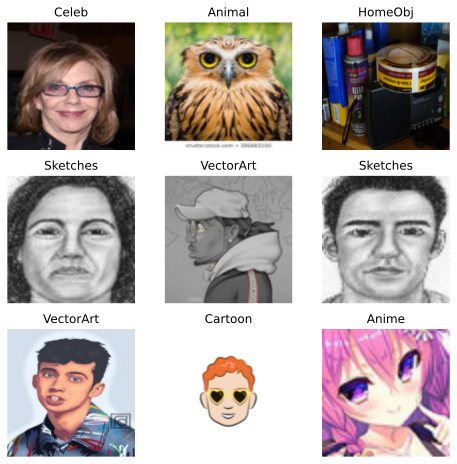

In [ ]:
#plot the images with the corresponding labels
fig,axes = plt.subplots(3,3,figsize=(8,8)) #we plot the images in 3 rows and 3 columnns, with a 8x8 size 
for i in range(3): #three rows
    for j in range(3): #three columns
        plt.sca(axes[i,j])
        idx = np.random.randint(0,31) #take random images from a batch of size 32
        image = np.moveaxis(images[idx].numpy(),0,2)
        plt.title(image_label[labels[idx].item()]) #show the label
        plt.imshow(image) #plot the image
        plt.axis('off')

Problem: Unbalanced classes, so we rebalance them using Glob and Os library and then we delete some classes that have too few pictures. 


We resize all the classes with an overall of about 220 images per class. 

In [ ]:
## we create our path to select the entire dataset on our Google Drive 
root_path='/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face'
## class_names is a list of all names of labels sorted in alphabetic order 
class_names_original = sorted(os.listdir(root_path))
n_class_original=len(class_names_original) #number of classes
## class_dis is a list of all lengths of each labels 
class_dis_original=[len(os.listdir(root_path + "/" + name)) for name in class_names_original]

In [ ]:
fig = px.bar(x = class_names_original, y = class_dis_original, text_auto='.2s', color = class_names_original) #create the histogram
fig.show() #show results

In [ ]:
import glob
def ber(p):
    if np.random.rand() <= p:
        return "1"
    else:
        return "0"


p=[0.15,0.15,0.045,0.18]
folder=["anime/*.png","cartoon/*.png","celeb/*.jpg","sketches/*.jpg"]
 
for i in range(4):
    for j in glob.glob("/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face/"+folder[i]):
        if ber(p[i]) == "0":
            os.remove(j)



In [ ]:
## we create our path to select the entire dataset on our Google Drive 
root_path='/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face'
## class_names is a list of all names of labels sorted in alphabetic order 
class_names_original = sorted(os.listdir(root_path))
n_class_original=len(class_names_original) #number of classes
## class_dis is a list of all lengths of each labels 
class_dis_original=[len(os.listdir(root_path + "/" + name)) for name in class_names_original]

In [ ]:

fig = px.bar(x = class_names_original, y = class_dis_original, text_auto='.2s', color = class_names_original) #create the histogram
fig.show() #show results


In [ ]:
len(my_dataset)

1926

##DIVISION IN: TRAIN, VALIDATION AND TEST

In [ ]:
#Update dataset with new amount of images per category
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PROGETTO DEEP LEARNING/Human_Face',
                                           transform=data_augmentation)

## Creating train validation and test sets about 0.7,0.15,0.15 respectively
 
train_set, val_set,test_set = torch.utils.data.random_split(my_dataset, [1348, 289, 289 ])

## We make train and test sets iterable in order to apply the neural network training function
train_iter=dataloader.DataLoader(train_set,batch_size=128,num_workers=0)
val_iter=dataloader.DataLoader(val_set,batch_size=30,num_workers=0)
test_iter=dataloader.DataLoader(test_set,batch_size=30,num_workers=0)

##FIRST ARCHITECTURE

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
#Define the total length of the batches for train and validation set 
total_batch=len(train_iter) #number of training images
def show_losses(model, val_iter):
  epochs=10 #number of epochs
  total_l_list=[] #initialize empty list
  validation_l_list=[] #initialize empty list
  validation_batch=len(val_iter) #number of test images. val_iter and test_iter have the same length
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001) #optimizer 
  for epoch in range(epochs):
    total_loss=0 #set loss to 0 at the start
    for num, data in enumerate(train_iter):
      X, y=data
      optimizer.zero_grad() 
      yhat=model.forward(X)
      loss=F.cross_entropy(yhat,y) #loss function
      total_loss+=loss #update total loss
      loss.backward()
      optimizer.step()
    total_l_list.append((total_loss/total_batch).detach().numpy()) #add the updated loss to the list
    with torch.no_grad():
      val_loss=0 #set loss to 0 at the start
      for num, data in enumerate(val_iter):
        val_x, val_y=data
        validation_out=model.forward(val_x)
        v_loss=F.cross_entropy(validation_out,val_y) #loss function
        val_loss+=v_loss #update total loss
      validation_l_list.append((val_loss/validation_batch).detach().numpy()) #add the updated loss to the list
  print(f'train loss: {total_loss/total_batch}')    #print results
  print(f'validation loss: {val_loss/validation_batch}')  #print results
  #plot results
  plt.plot([i for i in range(1,11)], [j for j in total_l_list], label='Train Loss') 
  plt.plot([i for i in range(1,11)], [j for j in validation_l_list], label='Test Loss') 
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Test and Train Loss')

First Net:
It is the simplest of those analyzed. It provides the *lowest* loss, but at the same time the *widest* distance between Train and Test accuracy 




In [ ]:
net1 = nn.Sequential(nn.BatchNorm2d(3),
    nn.Conv2d(3, 30, kernel_size=11, stride=4, padding=1), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(30, 96, kernel_size=5, padding=2), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 128, kernel_size=3, padding=1), nn.ReLU(), 
    nn.Conv2d(128, 96, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(2400, 2400), nn.ReLU(),                                           
    nn.Dropout(p=0.5), 
    
    nn.Linear(2400, 8))   

loss 0.483, train acc 0.815, test acc 0.758
1470.2 examples/sec on cuda:0


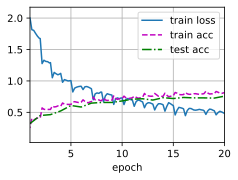

In [ ]:
lr, num_epochs = 0.01,20                                                                 
train(net1, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu())

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train loss: 0.33387959003448486
validation loss: 0.6581077575683594


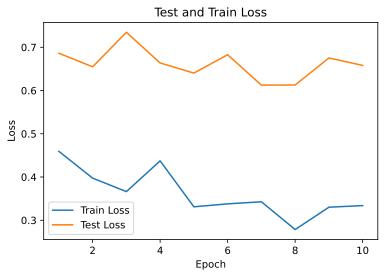

In [ ]:
net1.to('cpu')
show_losses(net1, test_iter)

Second Net: 
Before arriving at this net, we performed several steps to improve it. 

We initially added a *convolution* layer, then changed the pooling from MaxPool to AvgPool. 
At this point we noticed that the network was not providing significantly better values, because it decreased the distance of accuracy but at the cost of having a very high loss function. 

At this point we reduced the step of the last *linear transformation* from (2400, 8) to (1028, 8). As we can see, we get a loss function slightly larger than the first network, but by greatly reducing the distance between the two accuracies. 

In [ ]:
net3 = nn.Sequential(nn.BatchNorm2d(3),
    nn.Conv2d(3, 30, kernel_size=11, stride=4, padding=1), nn.ReLU(), #96==> 30
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(30, 96, kernel_size=5, padding=2), nn.ReLU(), #96==> 30, 256=>96
    nn.AvgPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 128, kernel_size=3, padding=1), nn.ReLU(), #reduce the 3 layers to 2
    nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 96, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool2d(kernel_size=3, stride=2),
    nn.Flatten(),                                                                           

    nn.Linear(2400, 1028), nn.ReLU(),      #riduzione output
    nn.Dropout(p=0.5), 
    nn.Linear(1028, 8))

loss 0.697, train acc 0.723, test acc 0.720
1375.8 examples/sec on cuda:0


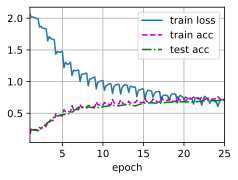

In [ ]:
#First, execute on validation set
lr, num_epochs = 0.01, 25
train(net3, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu())

train loss: 0.4361506700515747
validation loss: 0.7211195230484009


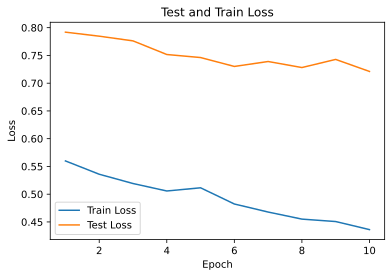

In [ ]:
net3.to('cpu')
show_losses(net3, test_iter)

Below we can find the probabilities of correctly predicting the image class (''classification report'')

In [ ]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
     for data in test_iter:
         images, labels = data     
         outputs = net3(images)
         _, predicted = torch.max(outputs, 1)
         c = (predicted == labels).squeeze()
         for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
for i in range(8):
     print('Accuracy of %5s : %2d %%' % (
            image_label[i], 100 * class_correct[i] / class_total[i]))


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of HomeObj : 60 %
Accuracy of NotFace : 50 %
Accuracy of Animal : 40 %
Accuracy of Anime : 85 %
Accuracy of Cartoon : 100 %
Accuracy of Celeb : 60 %
Accuracy of Sketches : 100 %
Accuracy of VectorArt : 50 %


##SECOND ARCHITECTURE 


The second architecture was then implemented.
As can be seen from the accuracy grades and the corresponding graph, although convolution layers were added and the inception class was defined, there is no evidence of improvement.
Through a process of "Trial and Error" we then sought the choice of parameters that would produce the best result.


In [ ]:
## Our Inception blocks consists in 5 paths concatenated. 
class Inception(nn.Module):
    ## `c1`--`c5` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, c5, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        ## Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        ## Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        ## convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        ## Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        ## convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        ## Path 4 is a 3 x 3 convolutional layer followed by a 1 x 1
        ## convolutional layer
        self.p4_1 = nn.Conv2d(in_channels,c4[0],kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(c4[0], c4[1], kernel_size=1)
        ## Path 5 is a 3x3 maximum pooling layer followed by a 1 x 1
        ## convolutional layer
        self.p5_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p5_2=nn.Conv2d(in_channels,c5,kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(x))))
        p5=F.relu(self.p5_2(self.p5_1(x)))
        ## Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4,p5), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.Conv2d(96,128,kernel_size=7,stride=2,padding=3),
                   nn.ReLU(),
                   nn.BatchNorm2d(128),
                   nn.Conv2d(128,100,kernel_size=7,stride=2,padding=3),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(100,128,kernel_size=3,padding=1),
                   nn.ReLU(),
                   nn.Conv2d(128, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.BatchNorm2d(192),
                   nn.Dropout(0.5),
                   nn.Conv2d(192,256,kernel_size=3,padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(256, 128, (96, 128), (16, 32), (32,64),64),
                   Inception(416, 128, (128, 192), (32, 96),(64,96),64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(576, 128, (96, 208), (16, 48), (64,78),64),
                   Inception(526, 128, (112, 224), (24, 64), (64,120),64),
                   Inception(600, 128, (128, 352), (24, 64), (64,96),64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:

b5 = nn.Sequential(Inception(704, 256, (160, 320), (32, 128), (128,222),128),
                   Inception(1054, 384, (192, 384), (48, 128), (128,352),128),
                   nn.AdaptiveAvgPool2d((1,1)), 
                   nn.Flatten())



In [ ]:
net5 = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1376, 8))

Training


loss 0.614, train acc 0.757, test acc 0.709
1610.5 examples/sec on cuda:0


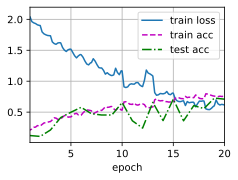

In [ ]:
lr, num_epochs = 0.01,20
d2l.train_ch6(net5, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu())

train loss: 0.23767980933189392
validation loss: 0.5142125487327576


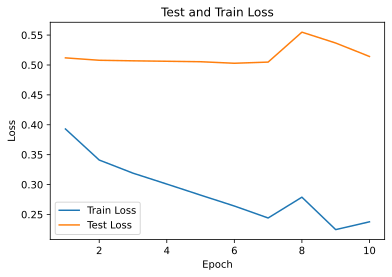

In [ ]:
net5.to('cpu')
show_losses(net5, test_iter)

CONCLUSION:
By making a comparison between the first and second architecture the following information is highlighted:
The first architecture appears to be more adequate, both in terms of accuracy and graphically.
A constraint common to both architectures is the poor sampling of the dataset, as we have seen our dataset contained about 2000 photos, thus forcing a very limited division of train/validation and test.
This leads us to infer that the dataset, not having a large number of "fetures," does not need overly complicated architectures.